In [15]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import train_test_dataloader_split,FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
!nvidia-smi
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
dataset = load_serialized_dataset('CircularHornDataset1')

train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.7)

train_params, train_fields = next(iter(train_dataloader))

kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=0.8,length_scale_bounds='fixed',nu=6.5)
std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor())])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))


In [3]:
test_ratios =  np.linspace(0.01,0.99,20)
training_size = []
train_loss = []
val_loss = []



for idx,test_ratio in enumerate(test_ratios):
    train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=test_ratio)
    train_params, train_fields = next(iter(train_dataloader))
    training_size.append(len(train_params))
    val_params, val_fields = next(iter(val_dataloader))
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))
    print(idx/len(test_ratios))



0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


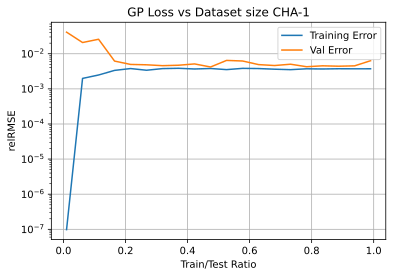

In [16]:
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
training_size = np.array(training_size)

plt.figure()
plt.semilogy(test_ratios,train_loss,label = 'Training Error')
plt.semilogy(test_ratios,val_loss,label = 'Val Error')
plt.title('GP Loss vs Dataset size CHA-1')
plt.xlabel('Train/Test Ratio')
plt.ylabel('relRMSE')
plt.grid()
plt.legend()
figSaver.save('GP_Loss_vs_Dataset_Size')